<a href="https://colab.research.google.com/github/felixn95/oil-palm-detection/blob/main/interpretation/interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation & Interpretation

#### In this notebook, the Interpretation of a well performing model was done using the ClassificationInterpretation of FastAI.

In [1]:
!pip install torch torchvision --q

In [2]:
!pip install timm wwf fastai neptune neptune-fastai --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.5/481.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.6 MB/s eta 0:00:00


Since we found no convienent way to host the already preprocessed dataset for easy reuse in colab runs, we just repeat the preprocessing steps here in one cell again. Informations therefore can be found in the preprocessing notebook in github.

In [3]:
import os
import pandas as pd

# load data set & unzip
os.environ['KAGGLE_USERNAME'] = 'felixn95'
os.environ['KAGGLE_KEY'] = 'f5ebbbcff77a95e44ac5acb1093c4c6a'

!kaggle competitions download -c widsdatathon2019
!unzip -q widsdatathon2019.zip
!unzip -q train_images.zip
!unzip -q leaderboard_test_data.zip

# Define Paths
train_images = '/content/train_images'
test_images =  '/content/leaderboard_test_data'
train_labels = '/content/traininglabels.csv'
test_labels = '/content/testlabels.csv'

def adjust_image_ids(input_csv_path, output_csv_path):
    """
    Adjusts the image_ids in the input CSV file by removing the year digits before '.jpg'
    and saves the modified DataFrame to the output CSV path.
    """

    df = pd.read_csv(input_csv_path)

    # Modify the 'image_id' column
    df['image_id'] = df['image_id'].str.replace(r'\d{4}\.jpg', '.jpg', regex=True)

    # Save to the output CSV file
    df.to_csv(output_csv_path, index=False)


adjust_image_ids(train_labels, 'traininglabels_processed.csv')
adjust_image_ids(test_labels, 'testlabels_processed.csv')

train_labels = '/content/traininglabels_processed.csv'
test_labels = '/content/testlabels_processed.csv'

def filter_missing_images(csv_file, image_dir, target_file):
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Filter out rows where the image file does not exist
    df_filtered = df[df['image_id'].apply(lambda x: os.path.exists(os.path.join(image_dir, x)))]

    # Save the filtered DataFrame
    df_filtered.to_csv(target_file, index=False)

filter_missing_images(train_labels, train_images, '/content/train_labels_filtered.csv')
filter_missing_images(test_labels, test_images, '/content/test_labels_filtered.csv')

train_labels = '/content/train_labels_filtered.csv'
test_labels = '/content/test_labels_filtered.csv'

100% 460M/460M [00:18<00:00, 29.0MB/s]
100% 460M/460M [00:18<00:00, 26.7MB/s]


# Training & Tracking

In [4]:
import os
import neptune
import torch
import wwf
import fastai
import timm
from wwf.vision.timm import timm_learner
from fastai.callback.all import SaveModelCallback
from fastai.vision.all import *
from neptune.integrations.fastai import NeptuneCallback
from neptune.types import File

def get_x(row, train_images):
    return os.path.join(train_images, row['image_id'])

def get_y(row):
    return row['has_oilpalm']

def create_dataloader(item_size, batch_size=64):
    # Create data block
    palm_data_block = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=partial(get_x, train_images=train_images),
        get_y=get_y,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        item_tfms=Resize(item_size),
        batch_tfms=aug_transforms()
    )

    # Create data loaders
    dls = palm_data_block.dataloaders(pd.read_csv(train_labels), bs=batch_size)
    return dls


## Created Methods for easier Training and Tracking

In [5]:
import neptune.new as neptune
from fastai.vision.all import *

# Modified function to return the learner

def train_model_with_optimal_lr(model, epochs, item_size, project_name, tag, batch_size):
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2ZjExOTA0Yy0zZjhhLTQ3Y2MtYjYzNy1kY2Q1OGMwODAyYWUifQ=="
    run = neptune.init_run(project=project_name, api_token=api_token, tags=[tag])

    dls = create_dataloader(item_size, batch_size)
    learner = vision_learner(dls, arch=model, metrics=accuracy)

    # Find optimal learning rate
    lr_min, lr_steep = learner.lr_find(suggest_funcs=(valley, steep))

    # Neptune callback
    neptune_cbk = NeptuneCallback(run=run)

    # Callback for logging metrics after each epoch
    class NeptuneRecorderCallback(Callback):
        def after_epoch(self):
            # Get the current epoch number
            epoch = self.learn.epoch

            # Log the accuracy
            accuracy = self.learn.recorder.metrics[-1].value
            run[f'epoch_{epoch}/accuracy'].log(accuracy)

            # Log the validation loss
            valid_loss = self.learn.recorder.log[-1]
            run[f'epoch_{epoch}/valid_loss'].log(valid_loss)

    # Train with callbacks
    learner.fit_one_cycle(epochs, lr_max=lr_min,
                          cbs=[SaveModelCallback(),
                               EarlyStoppingCallback(monitor='valid_loss', min_delta=0.02, patience=3),
                               neptune_cbk,
                               NeptuneRecorderCallback()])

    run.stop()
    learner.remove_cb(NeptuneCallback)

    # Save the learner for later use
    learner.export(f"./{tag}.pkl")

    # Return the learner for further use
    return learner

# Function to train multiple models and return the learners
def train_multiple_models_with_optimal_lr(models, epochs_list, item_size, project_name, batch_size):
    learners = {}
    for model in models:
        for epochs in epochs_list:
            tag = f'{model}_{epochs}_epochs'
            learner = train_model_with_optimal_lr(model, epochs, item_size, project_name, tag, batch_size)
            learners[tag] = learner  # Store the learner with its tag
    return learners




<ipython-input-5-e12503e75e8a>:1: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


# densenet169
Since the model performed as one of the best, we train it for a later interpretation on it.

<ipython-input-5-e12503e75e8a>:8: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  run = neptune.init_run(project=project_name, api_token=api_token, tags=[tag])


https://app.neptune.ai/tds-ws23/model-comparison/e/MOD1-35


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/57.4M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,0.454992,0.520190,0.781468,02:53
1,0.257915,0.227311,0.930588,02:50
2,0.239657,0.207539,0.933909,02:50
3,0.253398,0.384006,0.932248,02:51
4,0.211758,0.274517,0.933245,02:50


Better model found at epoch 0 with valid_loss value: 0.5201902389526367.
Better model found at epoch 1 with valid_loss value: 0.2273113876581192.
Better model found at epoch 2 with valid_loss value: 0.20753948390483856.
No improvement since epoch 1: early stopping
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 10 operations to synchronize with Neptune. Do not kill this process.
All 10 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tds-ws23/model-comparison/e/MOD1-35/metadata


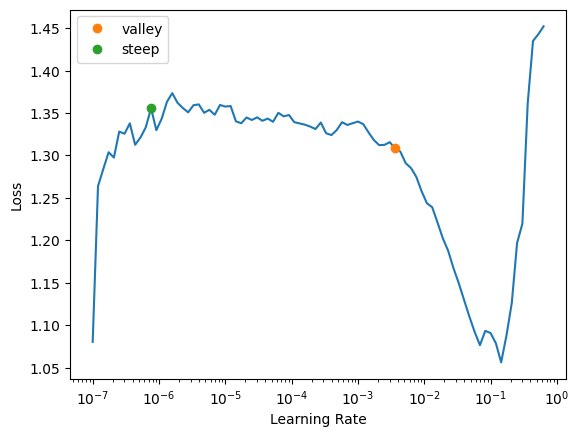

In [6]:
item_size = 256

# try different versions of densenet models

models = ["densenet169"]  # models to train
epochs_list = [7]  # epochs to test per models
project_name = 'model-comparison'
batch_size = 64

learners = train_multiple_models_with_optimal_lr(models, epochs_list, item_size, project_name, batch_size)

As can be seen in the overview, the best performance was done by

- densenet169 after 5 epochs
- accuracy: 0.933245

# Interpretation

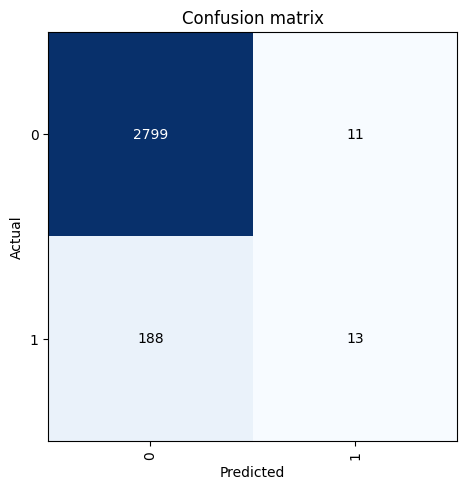

In [10]:
interp = ClassificationInterpretation.from_learner(learners['densenet169_7_epochs'])
interp.plot_confusion_matrix()

- True Positive (TP): 2799 instances were correctly predicted as class 0.
- False Negative (FN): 188 instances were incorrectly predicted as class 0 when they were actually class 1.
- False Positive (FP): 11 instances were incorrectly predicted as class 1 when they were actually class 0.
- True Negative (TN): 13 instances were correctly predicted as class 1.

The model seems to be better at predicting class 0 than class 1, as indicated by the higher number of TP for class 0 and TN for class 1. The presence of false negatives suggests that the model may struggle with identifying class 1 cases. This could be due to various factors, such as imbalanced dataset towards class 0 or model's sensitivity towards class 0 features.

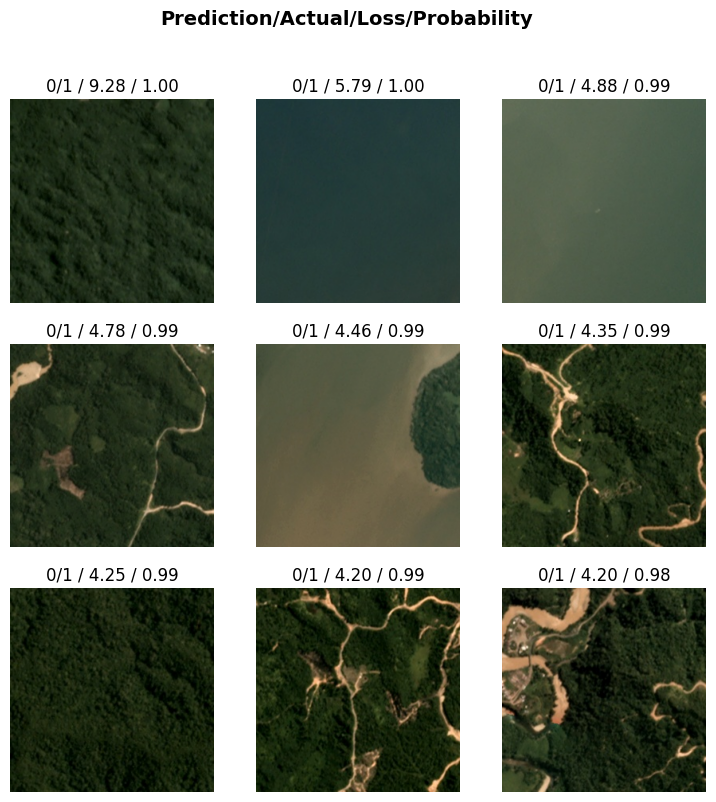

In [38]:
interp = ClassificationInterpretation.from_learner(learners['densenet169_7_epochs'])

# Plot top losses - primarily for visual inspection
k = 9  # Number of top losses to examine
interp.plot_top_losses(k)

# Correctly retrieve indices of top losses
top_losses, top_losses_indices = interp.top_losses(k)


- Prediction/Actual: The first number represents the model's prediction, and the second number represents the actual label of the image. A 0/1 means the model predicted the image as class 0, but the actual class was 1.

- Loss: This is a numerical value that represents how far off the prediction was from the actual label.

- Probability: This shows the model's confidence in its prediction. A value close to 1.00 indicates high confidence.

As already metioned above, the model has issues in predicting positive labeled images as negative.

In all top losses, the model predicted class 0 with high confidence (probability close to 1.00), but the actual class was 1, indicating that all predictions were incorrect. This might suggest that the model is not well-calibrated or struggles to differentiate between the classes for these particular types of images.

## Checking the confidence labeling score of the top losses

Since some of the top losses image seem to be labeled as positive, but not really looking like a plantation, let's have a look on the confidence of the labelers if this is an oil palm plantation.

In [39]:
# Get the image id's
top_losses, top_losses_indices = interp.top_losses(9)
top_losses_indices = top_losses_indices.tolist()
items_df = learners['densenet169_7_epochs'].dls.dataset.items
image_ids = items_df.iloc[top_losses_indices]['image_id'].values
print (image_ids)

['img_01020.jpg' 'img_00284.jpg' 'img_06973.jpg' 'img_05157.jpg'
 'img_07880.jpg' 'img_09269.jpg' 'img_04304.jpg' 'img_02951.jpg'
 'img_04519.jpg']


In [35]:
# get the according scores from the label csv
df = pd.read_csv(test_labels)
# Print out the image IDs and their scores
for image_id in image_ids:
    score = items_df[items_df['image_id'] == image_id]['score'].values[0]
    print(f"{image_id}: {score}")

img_01020.jpg: 0.8107
img_00284.jpg: 1.0
img_06973.jpg: 1.0
img_05157.jpg: 1.0
img_07880.jpg: 1.0
img_09269.jpg: 1.0
img_04304.jpg: 1.0
img_02951.jpg: 1.0
img_04519.jpg: 1.0


This confidence scores could imply, that maybe some images are labeled "wrong", since the labels origin from "confidence score based on the aggregated results from crowdsourcing the annotations." (see https://www.kaggle.com/c/widsdatathon2019/data).